In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

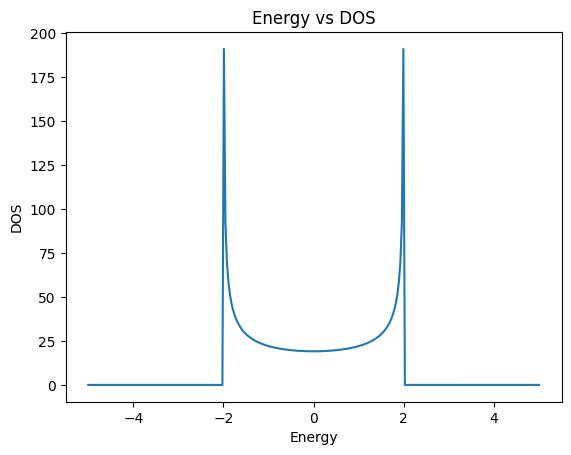

In [2]:
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)


energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [3]:
N = ham.get_num_sites()
pot = [sp.eye(1)*0]*N
pot[N//3] += sp.eye(1) * 0.3
pot[N//3 + 1] += sp.eye(1) * 0.3


pot[2 * N//3] += sp.eye(1) * 0.5
pot[2 * N//3 + 1] += sp.eye(1) * 0.5

In [4]:
ham.potential = pot

ham.get_potential(False)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (120, 120)>

In [6]:
X = ham.create_hamiltonian(False)

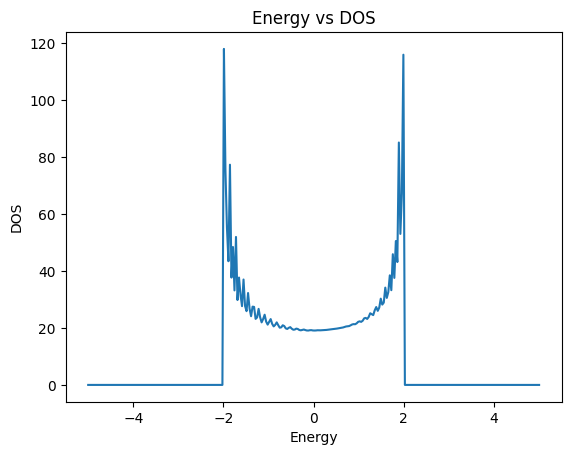

In [7]:
energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

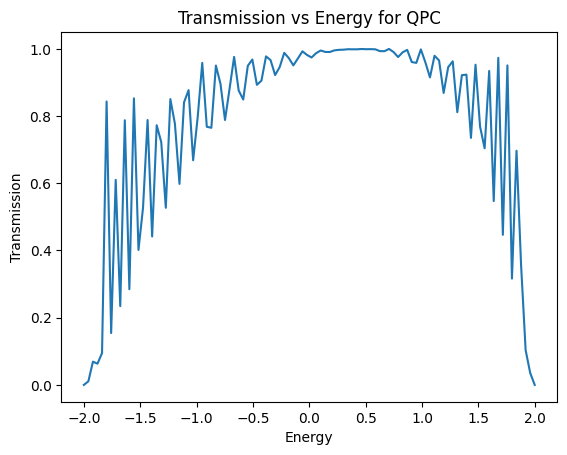

In [8]:
energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [7]:
x = gf.compute_charge_density()
x

array([0.5406927 , 0.55419245, 0.55171395, 0.53286352, 0.49781456,
       0.46853113, 0.45886302, 0.46664148, 0.46866358, 0.45628155,
       0.43348949, 0.42041523, 0.42072058, 0.43050521, 0.4406504 ,
       0.45985766, 0.48761024, 0.51767615, 0.53225023, 0.53113956,
       0.51966416, 0.51719966, 0.52807697, 0.54926963, 0.56058424,
       0.55975986, 0.5491097 , 0.54234248, 0.5348916 , 0.52855544,
       0.51625323, 0.50672341, 0.49807971, 0.50312132, 0.51372974,
       0.53050809, 0.52947714, 0.52215691, 0.49681913, 0.49994808,
       0.43135995, 0.42951461, 0.48505465, 0.46093153, 0.45310586,
       0.43085356, 0.41154747, 0.3947085 , 0.39343929, 0.40412873,
       0.42096675, 0.43317846, 0.43715929, 0.43403685, 0.42491124,
       0.41211679, 0.39984834, 0.39940642, 0.41393483, 0.43860397,
       0.45465533, 0.45269677, 0.43124243, 0.4086068 , 0.39593484,
       0.40172198, 0.41358756, 0.42757513, 0.43344058, 0.43749021,
       0.43149625, 0.42385373, 0.408212  , 0.40258403, 0.39947

In [9]:
# Test different integration methods
print("Testing uniform grid method (original):")
n_density_uni = gf.get_n(V=np.zeros_like(x), Efn=np.ones_like(x)*-0, Ec=-2.0, method='gauss_fermi', num_points=64, processes=32)
print(n_density_uni)


Testing uniform grid method (original):
Running in parallel mode with 32 processes.
[0.52923581 0.53764351 0.51150329 0.52941019 0.50690709 0.51270839
 0.51185932 0.49930721 0.52251911 0.49813145 0.51483519 0.49928235
 0.49966221 0.51019453 0.48489032 0.53163237 0.50203842 0.4906228
 0.51509584 0.47453709 0.50739459 0.51365531 0.49421536 0.54590628
 0.48777198 0.43842063 0.51880777 0.51967247 0.47961991 0.54755534
 0.55618428 0.44506575 0.39996368 0.49067452 0.57241307 0.5712051
 0.51635959 0.48352019 0.46703483 0.48939672 0.43264407 0.43540031
 0.49457568 0.4657542  0.44713367 0.41179566 0.39184047 0.39585429
 0.42749138 0.45501947 0.44992991 0.42567821 0.41322612 0.41556903
 0.41782799 0.42432182 0.43869043 0.43760099 0.42654277 0.42472659
 0.41845276 0.41883632 0.42172131 0.42712598 0.44163355 0.4426165
 0.42055651 0.41415141 0.41098009 0.41119807 0.43062856 0.46620474
 0.45927227 0.41588753 0.37544804 0.38783481 0.42080406 0.4701506
 0.48035758 0.51741555 0.4035798  0.40218685 0.51

In [ ]:
# Sweep Fermi energy and plot transmission for QPC
ham = Hamiltonian("qpc")

ham.W = 10
ham.L = 30
ham.t = 1.0
ham.o = 0.0
ham.Vg = .1  # Moderate barrier

gf = GreensFunction(ham)

energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:


# # --- Plotting Code ---

# # Extract x and y coordinates from the list of Atom objects
# x_coords = [atom.x for atom in structure]
# y_coords = [atom.y for atom in structure]

# # Create the plot
# plt.figure(figsize=(8, 12))
# plt.scatter(x_coords, y_coords, s=150, edgecolors='black', facecolors='skyblue', zorder=5)

# # Add text labels to identify each atom's index in the list
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.text(x + 0.05, y + 0.05, str(i), fontsize=9, ha='left', va='bottom', zorder=10)

# # Formatting the plot for clarity
# plt.title("Plot of Generated Atom Coordinates", fontsize=16)
# plt.xlabel("X coordinate", fontsize=12)
# plt.ylabel("Y coordinate", fontsize=12)
# plt.axis('equal')  # This is CRUCIAL for correctly visualizing geometric structures
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

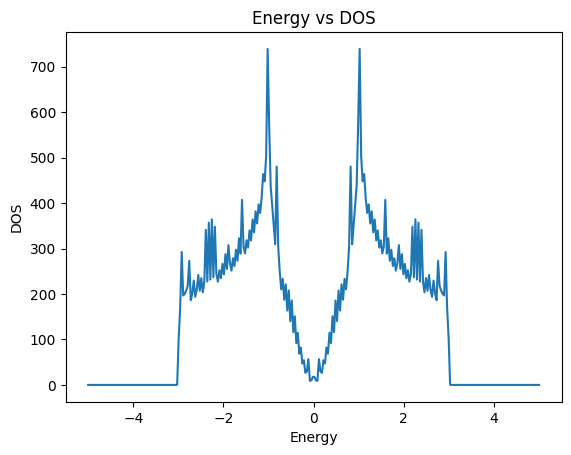

In [3]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag")
ham.Nx=20
ham.Ny=20

gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = [None] * 300

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()





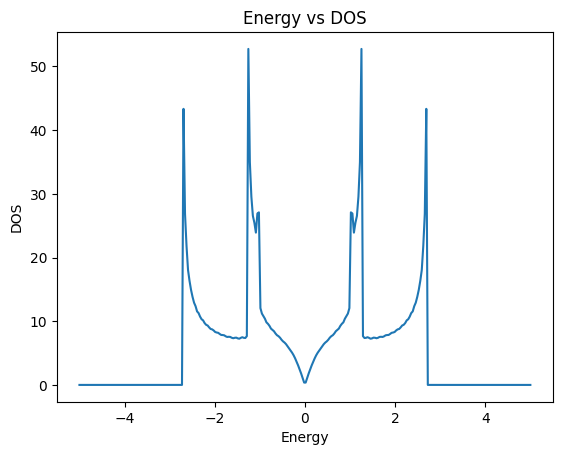

In [2]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag", periodic=True)
ham.Nx=20


gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = [None] * 300

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()





In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("zigzag", False)


gf = GreensFunction(ham)



energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()

In [2]:
print(dos)

[np.float64(7.807965483691064e-06), np.float64(7.97029280188766e-06), np.float64(8.1383519120542e-06), np.float64(8.312440500073281e-06), np.float64(8.49287712432992e-06), np.float64(8.680003083744241e-06), np.float64(8.874184491083746e-06), np.float64(9.075814578489676e-06), np.float64(9.285316266283943e-06), np.float64(9.503145030985289e-06), np.float64(9.729792114200793e-06), np.float64(9.96578812085222e-06), np.float64(1.021170706326557e-05), np.float64(1.0468170917270353e-05), np.float64(1.0735854767960029e-05), np.float64(1.1015492636579546e-05), np.float64(1.130788409665676e-05), np.float64(1.1613901807647626e-05), np.float64(1.1934500118858884e-05), np.float64(1.2270724926315507e-05), np.float64(1.2623725001916816e-05), np.float64(1.299476505942998e-05), np.float64(1.3385240877869064e-05), np.float64(1.3796696872555063e-05), np.float64(1.4230846591512025e-05), np.float64(1.4689596724927752e-05), np.float64(1.5175075354972282e-05), np.float64(1.568966535140098e-05), np.float64(1

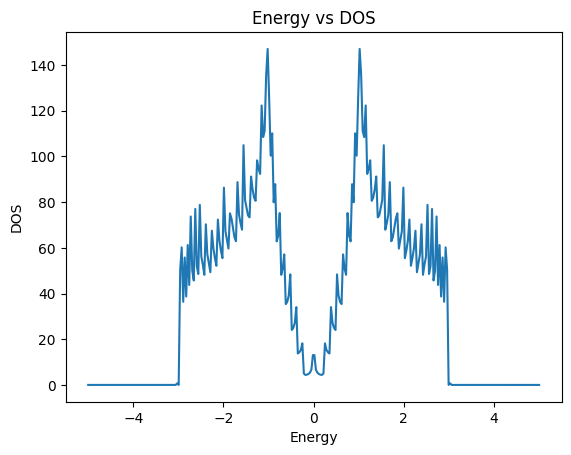

In [3]:

plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()